In [1]:
import pandas as pd
from math import ceil
import numpy as np
import pydot as pt
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

import lightgbm as lgb
import os
#print(os.listdir("../input"))
import sys

In [3]:
train_df = pd.read_csv('train.csv', low_memory = False)
test_df = pd.read_csv('test.csv')

train_df = train_df.drop('ID_code', axis = 1)
test_df = test_df.drop('ID_code', axis = 1)

train_df = train_df.apply(pd.to_numeric)
test_df = test_df.apply(pd.to_numeric)

In [4]:
train_df.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [5]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [6]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']
param = {
    'bagging_freq': 5,          'bagging_fraction': 0.38,   'boost_from_average':'false',   'boost': 'gbdt',
    'feature_fraction': 0.045,   'learning_rate': 0.0105,     'max_depth': -1,                'metric':'auc',
    'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
    'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}

In [7]:
from sklearn.model_selection import StratifiedKFold
folds = StratifiedKFold(n_splits = 12, shuffle = False, random_state = 44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [8]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold :{}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label = target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label = target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 100000, valid_sets = [trn_data, val_data], verbose_eval = 1000, early_stopping_rounds = 1000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration = clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration = clf.best_iteration) / folds.n_splits
sys.stdout.write("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold :1
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.901299	valid_1's auc: 0.882845
[2000]	training's auc: 0.912408	valid_1's auc: 0.890959
[3000]	training's auc: 0.91966	valid_1's auc: 0.895358
[4000]	training's auc: 0.925196	valid_1's auc: 0.897666
[5000]	training's auc: 0.929874	valid_1's auc: 0.89883
[6000]	training's auc: 0.934074	valid_1's auc: 0.899669
[7000]	training's auc: 0.937927	valid_1's auc: 0.900239
[8000]	training's auc: 0.941703	valid_1's auc: 0.900637
[9000]	training's auc: 0.945214	valid_1's auc: 0.900805
[10000]	training's auc: 0.948602	valid_1's auc: 0.9007
Early stopping, best iteration is:
[9281]	training's auc: 0.946207	valid_1's auc: 0.900846
Fold :2
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.900982	valid_1's auc: 0.885907
[2000]	training's auc: 0.912388	valid_1's auc: 0.891921
[3000]	training's auc: 0.919733	valid_1's auc: 0.894824
[4000]	training's auc: 0.925317	valid_1'

In [9]:
#sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
#sub["target"] = predictions
#sub.to_csv('submission.csv', index=False)

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_df[train_df.columns.values[1:]], 
                                                    train_df[train_df.columns.values[0]], 
                                                    test_size = 0.3, random_state = 2019)

In [19]:
print(X_train.shape, X_test.shape)

(140000, 200) (60000, 200)


In [20]:
# work with X_train, X_test, y_train, y_test
# Create an object of Logistic Regression with parameters C and class_weight
logist = LogisticRegression(C = 0.001, class_weight = 'balanced')

# Fit the training data on this object
logist.fit(X_train, y_train)

/home/dind-vm/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [21]:
# Predict the Target for validation dataset 
logist_pred = logist.predict_proba(X_test)[:,1]

In [22]:
def performance(Y_test, logist_pred):
    logist_pred_var = [0 if i < 0.5 else 1 for i in logist_pred]
    print('Confusion Matrix:')
    print(confusion_matrix(Y_test, logist_pred_var)) 
      
    #print(classification_report(Y_test, logist_pred)) 

    fpr, tpr, thresholds = roc_curve(Y_test, logist_pred, pos_label = 1)
    print('AUC:')
    print(auc(fpr, tpr))

In [23]:
performance(y_test, logist_pred)

Confusion Matrix:
[[42214 11737]
 [ 1404  4645]]
AUC:
0.8541970967765768


In [24]:
# Create Decision Tree Classifier object with few parameters
tree_clf = DecisionTreeClassifier(class_weight = 'balanced', random_state = 2019, 
                                  max_features = 0.7, min_samples_leaf = 80)

# Fit the object on training data
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=0.7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=80, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2019,
            splitter='best')

In [25]:
# Predict for validation set and check the performance
tree_preds = tree_clf.predict_proba(X_test)[:, 1]
performance(y_test, tree_preds)

Confusion Matrix:
[[35314 18637]
 [ 2629  3420]]
AUC:
0.6514727493199708


In [26]:
# Create random Forest Object using the mentioned parameters
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 2019, verbose = 1,
                                      class_weight = 'balanced', max_features = 0.5, 
                                       min_samples_leaf = 100)

# Fit the object on training set 
random_forest.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 28.4min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=2019, verbose=1, warm_start=False)

In [27]:
# Predict the validation set target and check the performance
forest_preds = random_forest.predict_proba(X_test)[:, 1]
performance(y_test, forest_preds)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Confusion Matrix:
[[46548  7403]
 [ 2978  3071]]
AUC:
0.7872813411975419


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [28]:
from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, RepeatVector, Lambda, Permute, Activation, Masking, Reshape
from keras.layers import recurrent, Input, TimeDistributed, add, concatenate, Multiply, Bidirectional
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization

from keras.activations import softmax
from keras.metrics import categorical_accuracy
import keras.backend as K
from keras.regularizers import l2
from keras import initializers
#from keras.utils.visualize_util import plot
from keras.layers.core import Layer

from keras.activations import softmax, tanh, sigmoid, hard_sigmoid, relu

Using TensorFlow backend.


In [29]:
def create_models(in_shape):
    adam = Adam(lr = 0.0003)  # Best learning found in previous exp
    input_layer = Input(shape = (in_shape,), name = 'input_layer')
    dense = Dense(100, activation = 'relu')(input_layer)
    #dense = Dropout(0.35)(dense)
    dense = Dense(50, activation = 'relu')(dense)
    dense = Dropout(0.30)(dense)
    output = Dense(2, activation = 'softmax')(dense)
    model = Model(inputs = input_layer, outputs = output)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    #model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    #tf_thetas = tf.get_variable("tf_thetas",
    #                        initializer=thetas)

    #sample_output = Lambda(lambda x: 
    #               gumbel_softmax(x, temperature,  hard = hard_val), 
    #               output_shape = (2,))(output)
    #cond_prob = Lambda(lambda x: tf.einsum('ai,ij->aj', x[0], tf_thetas*1.),
    #          output_shape = (2, ))([sample_output])

    #model_ask = Model(inputs = input_layer, outputs = cond_prob)
    #model_ask.compile(loss = 'categorical_crossentropy', 
    #              optimizer = adam, metrics = ['accuracy'])
    
    return model#, model_ask

In [30]:
random_idx = np.random.choice(len(X_train), len(X_train), replace = False)

X_train_nn = X_train.iloc[random_idx]
y_train_nn = y_train.iloc[random_idx]

In [31]:
K.clear_session()
model = create_models(X_train.shape[1])

In [32]:
from keras.utils import to_categorical
y_binary_train = to_categorical(y_train)
y_binary_test = to_categorical(y_test)

In [33]:
# Make severl models, computes and average them. Consider Kfold, SVM, NN, Logisteic Regression, Light GBM and several configurations of them
h = model.fit(X_train, y_binary_train, 
              epochs = 50, validation_data = (X_test, y_binary_test),
              batch_size = 25,
              verbose = 1)

Train on 140000 samples, validate on 60000 samples
Epoch 1/50
140000/140000 [==============================] - 18s 125us/step - loss: 0.3008 - acc: 0.8999 - val_loss: 0.2594 - val_acc: 0.9028
Epoch 2/50
140000/140000 [==============================] - 14s 103us/step - loss: 0.2606 - acc: 0.9064 - val_loss: 0.2495 - val_acc: 0.9092
Epoch 3/50
140000/140000 [==============================] - 14s 100us/step - loss: 0.2562 - acc: 0.9072 - val_loss: 0.2474 - val_acc: 0.9088
Epoch 4/50
140000/140000 [==============================] - 14s 102us/step - loss: 0.2541 - acc: 0.9072 - val_loss: 0.2458 - val_acc: 0.9095
Epoch 5/50
140000/140000 [==============================] - 14s 99us/step - loss: 0.2514 - acc: 0.9075 - val_loss: 0.2460 - val_acc: 0.9097
Epoch 6/50
140000/140000 [==============================] - 14s 103us/step - loss: 0.2505 - acc: 0.9086 - val_loss: 0.2489 - val_acc: 0.9095
Epoch 7/50
140000/140000 [==============================] - 13s 91us/step - loss: 0.2499 - acc: 0.9091 -

In [34]:
y_predicted_nn = model.predict(X_test)

In [35]:
temp_nn_predic = []
for i in range(len(y_predicted_nn)):
    if y_predicted_nn[i,0] > y_predicted_nn[i,1]:
        temp_nn_predic.append(0)
    else:
        temp_nn_predic.append(1)

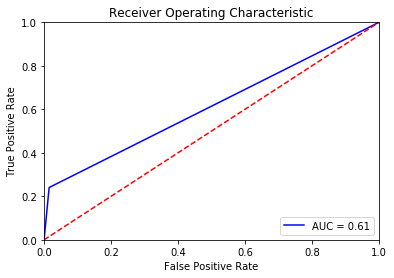

In [36]:
# There is no gain with more layers!
fpr_nn, tpr_nn, threshold_nn = roc_curve(y_test, temp_nn_predic)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_nn, tpr_nn, 'b', label = 'AUC = %0.2f' % roc_auc_nn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()